In [6]:
# config (run before anything else)
import pandas as pd
import warnings
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import itertools


warnings.filterwarnings(
    "ignore",
    message=r"unknown class\(es\).*will be ignored",
    module="sklearn.preprocessing._label",
)

warnings.filterwarnings(
    "ignore",
    message="The parameter 'token_pattern' will not be used since 'analyzer' != 'word'",
    module="sklearn.feature_extraction.text",
)

LOG_RESULTS = True
N_SPLITS = 5  # number of folds
RANDOM_SEED = 42

input_files = {
    "all_inputs_default": "data/experiments/all_inputs.csv",
    "preprocessed": "data/strong_baseline/folds_preprocessed.csv",
    "custom_words_removed": "data/experiments/custom_words_removed.csv",
    "allfeatures": "data/feature_engineering/folds_allfeatures.csv",
    "lemmatization": "data/experiments/lemmatization.csv",
    "stemming": "data/experiments/stemming.csv",
    "sub_words": "data/experiments/sub_words/sub_words.csv",
    "lemmatized_sub_words": "data/experiments/sub_words/lemmatized_sub_words.csv",
}

models = [
    (SVC, {"kernel": "linear"}, "Linear SVC"),
    (LogisticRegression, {"max_iter": 1000}, "Logistic Regression"),
    (LGBMClassifier, {"verbose": -1, "force_row_wise": True}, "LightGBM"),
    (MultinomialNB, {}, "Multinomial Naive Bayes"),
    (RandomForestClassifier, {"n_estimators": 200, "n_jobs": -1}, "Random Forest"),
    (RidgeClassifier, {}, "Ridge Classifier"),
    (ComplementNB, {}, "Complement Naive Bayes"),
    (SGDClassifier, {"loss": "log_loss", "max_iter": 1000}, "SGD Logistic Regression"),
]

tfidf_configs = [
    # --- Baselines ---
    {
        "description": "Baseline (Unigrams only)",
        "ngram_range": (1, 1),
        "min_df": 1,
        "max_df": 1.0,
    },
    {
        "description": "Unigrams + Bigrams",
        "ngram_range": (1, 2),
        "min_df": 1,
        "max_df": 1.0,
    },
    # --- Term filtering ---
    {
        "description": "Unigrams, ignore very rare terms (min_df=5)",
        "ngram_range": (1, 1),
        "min_df": 5,
        "max_df": 1.0,
    },
    {
        "description": "Unigrams, ignore very common terms (max_df=0.9)",
        "ngram_range": (1, 1),
        "min_df": 1,
        "max_df": 0.9,
    },
    {
        "description": "Unigrams + Bigrams, with term filtering",
        "ngram_range": (1, 2),
        "min_df": 5,
        "max_df": 0.9,
    },
    # --- Trigrams ---
    {
        "description": "Unigrams + Bigrams + Trigrams (capped)",
        "ngram_range": (1, 3),
        "min_df": 10,
        "max_df": 0.9,
        "max_features": 300_000,
    },
    {
        "description": "Bigrams + Trigrams (capped)",
        "ngram_range": (2, 3),
        "min_df": 10,
        "max_df": 0.9,
        "max_features": 300_000,
    },
    {
        "description": "Unigrams + Bigrams + Trigrams, with term filtering (capped)",
        "ngram_range": (1, 3),
        "min_df": 5,
        "max_df": 0.9,
        "max_features": 300_000,
    },
    {
        "description": "Bigrams only",
        "ngram_range": (2, 2),
        "min_df": 2,
        "max_df": 0.95,
    },
    {
        "description": "Trigrams only",
        "ngram_range": (3, 3),
        "min_df": 2,
        "max_df": 0.95,
    },
    # --- Character n-grams ---
    {
        "description": "Character n-grams (3–5 chars, capped)",
        "analyzer": "char",
        "ngram_range": (3, 5),
        "min_df": 5,
        "max_df": 0.9,
        "max_features": 200_000,
    },
    {
        "description": "Character n-grams (4–6 chars, capped)",
        "analyzer": "char",
        "ngram_range": (4, 6),
        "min_df": 5,
        "max_df": 0.9,
        "max_features": 200_000,
    },
]

# feature combinations
features = ["Text", "Numerical"]
feature_combinations = [
    combo
    for r in range(1, len(features) + 1)
    for combo in itertools.combinations(features, r)
]

text_features = "document"
numerical_features = [
    "month_sin",
    "month_cos",
    "dow_sin",
    "dow_cos",
    "n_ingredients",
    "n_steps",
    "description_length",
    "recipe_name_length",
    "mentions_time",
    "mentions_temp",
    "n_actions",
    "avg_step_length",
    "tokens_per_step",
]

categorical_features = None

results = pd.DataFrame(columns=["Algorithm", "Accuracy", "Training_Time_s"])

## Beyond SVC: Comparing Other Classifiers

While `SVC` is a strong baseline, it is important to explore a broader range of algorithms commonly used in text classification. In addition to Support Vector Machines, we evaluate the following models:

- **Naive Bayes family**: `MultinomialNB` and `ComplementNB` — fast and effective baselines for sparse text features.
- **Linear models**: `Logistic Regression`, `Ridge Classifier`, and `SGDClassifier` — scalable and well-suited for high-dimensional TF-IDF representations.
- **Tree ensembles**: `Random Forest` and gradient boosting methods such as `LightGBM` — capable of capturing non-linear feature interactions.

Each model is trained and evaluated systematically using K-fold cross-validation. Results are logged for reproducibility and comparison across experiments. Consistent preprocessing (TF-IDF vectorization, scaling, and encoding) is enforced through the experimental pipeline, built on `scikit-learn` and extended where necessary.


### With all inputs

(Preprocessed text columns from preprocessing. Tests different models and different TF-IDF configs for each model)


In [ ]:
from utils import run_configs, print_results_table
import pandas as pd

# config
INPUT_FILE = input_files["all_inputs_default"]

new_results = run_configs(
    # models=models[5:], # sliced so it doesn't run everything again
    models=models,
    folds_path=INPUT_FILE,
    what_data="all_inputs_default",
    tfidf_configs=tfidf_configs,
    feature_combinations=feature_combinations,
    text_features=text_features,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    random_seed=RANDOM_SEED,
    log_results=LOG_RESULTS,
)

results = (
    pd.concat([results, new_results], ignore_index=True)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

print_results_table(
    results, title="PREPROCESSED & ALL INPUTS × TF-IDF CONFIGS", top_n=10
)

Model: SVC
Cross-Validation (using data/experiments/all_inputs.csv)
  Fold 1: 0.8533
  Fold 2: 0.8533
  Fold 3: 0.8483
  Fold 4: 0.8433
  Fold 5: 0.8447
Mean accuracy: 0.8486  |  Std: 0.0047
Total runtime: 14.90 seconds
➕ Added new results for 'Linear SVC (all_inputs_default data) | Text | Baseline (Unigrams only)'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/all_inputs.csv)
  Fold 1: 0.8883
  Fold 2: 0.8767
  Fold 3: 0.8767
  Fold 4: 0.8617
  Fold 5: 0.8564
Mean accuracy: 0.8720  |  Std: 0.0128
Total runtime: 45.53 seconds
➕ Added new results for 'Linear SVC (all_inputs_default data) | Text | Unigrams + Bigrams'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/all_inputs.csv)
  Fold 1: 0.8633
  Fold 2: 0.8550
  Fold 3: 0.8450
  Fold 4: 0.8450
  Fold 5: 0.8464
Mean accuracy: 0.8509  |  Std: 0.0081
Total runtime: 13.07 seconds
➕ Added new results for 'Linear SVC (all_inputs_default data) | Text | Unigram

/var/folders/49/m9x4wxwn0q1b6yl_x3dpynqm0000gn/T/ipykernel_14825/2071855298.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([results, new_results], ignore_index=True)


### Same as the above, but also removes custom words from text column

Words removed: great, make, recipe, dish, one

(Results are cumulative; previous entries remain visible in the output if they rank within the top 10.)


In [14]:
from utils import run_configs, print_results_table
import pandas as pd

# config
INPUT_FILE = input_files["custom_words_removed"]


new_results = run_configs(
    models=models,
    folds_path=INPUT_FILE,
    what_data="custom_words_removed",
    tfidf_configs=tfidf_configs,
    feature_combinations=feature_combinations,
    text_features=text_features,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    random_seed=RANDOM_SEED,
    log_results=LOG_RESULTS,
)

# concats previous results with new and sorts by accuracy
results = (
    pd.concat([results, new_results], ignore_index=True)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

print_results_table(
    results,
    title="PREPROCESSED DATA WITH CUSTOM WORDS REMOVED (TF-IDF CONFIGS)",
    top_n=10,
)

Model: SVC
Cross-Validation (using data/experiments/custom_words_removed.csv)
  Fold 1: 0.8517
  Fold 2: 0.8533
  Fold 3: 0.8517
  Fold 4: 0.8417
  Fold 5: 0.8447
Mean accuracy: 0.8486  |  Std: 0.0051
Total runtime: 15.47 seconds
➕ Added new results for 'Linear SVC (custom_words_removed data) | Text | Baseline (Unigrams only)'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/custom_words_removed.csv)
  Fold 1: 0.8883
  Fold 2: 0.8800
  Fold 3: 0.8767
  Fold 4: 0.8550
  Fold 5: 0.8531
Mean accuracy: 0.8706  |  Std: 0.0157
Total runtime: 47.21 seconds
➕ Added new results for 'Linear SVC (custom_words_removed data) | Text | Unigrams + Bigrams'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/custom_words_removed.csv)
  Fold 1: 0.8600
  Fold 2: 0.8500
  Fold 3: 0.8433
  Fold 4: 0.8433
  Fold 5: 0.8414
Mean accuracy: 0.8476  |  Std: 0.0077
Total runtime: 13.86 seconds
➕ Added new results for 'Linear SVC (custom_

### Lemmatization


In [15]:
from utils import run_configs, print_results_table

# config
INPUT_FILE = input_files["lemmatization"]

new_results = run_configs(
    models=models,
    folds_path=INPUT_FILE,
    what_data="lemmatization",
    tfidf_configs=tfidf_configs,
    feature_combinations=feature_combinations,
    text_features=text_features,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    random_seed=RANDOM_SEED,
    log_results=LOG_RESULTS,
)

results = (
    pd.concat([results, new_results], ignore_index=True)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

print_results_table(results, title="LEMMATIZATION DATA (TF-IDF CONFIGS)", top_n=10)

Model: SVC
Cross-Validation (using data/experiments/lemmatization.csv)
  Fold 1: 0.8483
  Fold 2: 0.8550
  Fold 3: 0.8417
  Fold 4: 0.8417
  Fold 5: 0.8331
Mean accuracy: 0.8439  |  Std: 0.0082
Total runtime: 14.84 seconds
➕ Added new results for 'Linear SVC (lemmatization data) | Text | Baseline (Unigrams only)'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/lemmatization.csv)
  Fold 1: 0.8800
  Fold 2: 0.8750
  Fold 3: 0.8733
  Fold 4: 0.8567
  Fold 5: 0.8581
Mean accuracy: 0.8686  |  Std: 0.0106
Total runtime: 46.91 seconds
➕ Added new results for 'Linear SVC (lemmatization data) | Text | Unigrams + Bigrams'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/lemmatization.csv)
  Fold 1: 0.8433
  Fold 2: 0.8517
  Fold 3: 0.8400
  Fold 4: 0.8350
  Fold 5: 0.8314
Mean accuracy: 0.8403  |  Std: 0.0078
Total runtime: 13.54 seconds
➕ Added new results for 'Linear SVC (lemmatization data) | Text | Unigrams, ign

### Stemming


In [16]:
from utils import run_configs, print_results_table

# config
INPUT_FILE = input_files["stemming"]

new_results = run_configs(
    models=models,
    folds_path=INPUT_FILE,
    what_data="stemming",
    tfidf_configs=tfidf_configs,
    feature_combinations=feature_combinations,
    text_features=text_features,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    random_seed=RANDOM_SEED,
    log_results=LOG_RESULTS,
)

results = (
    pd.concat([results, new_results], ignore_index=True)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

print_results_table(results, title="STEMMING DATA (TF-IDF CONFIGS)", top_n=10)

Model: SVC
Cross-Validation (using data/experiments/stemming.csv)
  Fold 1: 0.8283
  Fold 2: 0.8433
  Fold 3: 0.8433
  Fold 4: 0.8317
  Fold 5: 0.8347
Mean accuracy: 0.8363  |  Std: 0.0068
Total runtime: 14.38 seconds
➕ Added new results for 'Linear SVC (stemming data) | Text | Baseline (Unigrams only)'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/stemming.csv)
  Fold 1: 0.8767
  Fold 2: 0.8667
  Fold 3: 0.8717
  Fold 4: 0.8583
  Fold 5: 0.8598
Mean accuracy: 0.8666  |  Std: 0.0078
Total runtime: 46.37 seconds
➕ Added new results for 'Linear SVC (stemming data) | Text | Unigrams + Bigrams'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/stemming.csv)
  Fold 1: 0.8300
  Fold 2: 0.8283
  Fold 3: 0.8417
  Fold 4: 0.8233
  Fold 5: 0.8347
Mean accuracy: 0.8316  |  Std: 0.0069
Total runtime: 13.30 seconds
➕ Added new results for 'Linear SVC (stemming data) | Text | Unigrams, ignore very rare terms (min_df=5)

### Sub-words


In [17]:
from utils import run_configs, print_results_table

# config
INPUT_FILE = input_files["sub_words"]

new_results = run_configs(
    models=models,
    folds_path=INPUT_FILE,
    what_data="sub_words",
    tfidf_configs=tfidf_configs,
    feature_combinations=feature_combinations,
    text_features=text_features,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    random_seed=RANDOM_SEED,
    log_results=LOG_RESULTS,
)

results = (
    pd.concat([results, new_results], ignore_index=True)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

print_results_table(results, title="SUB-WORDS DATA (TF-IDF CONFIGS)", top_n=10)

Model: SVC
Cross-Validation (using data/experiments/sub_words/sub_words.csv)
  Fold 1: 0.8617
  Fold 2: 0.8583
  Fold 3: 0.8617
  Fold 4: 0.8517
  Fold 5: 0.8481
Mean accuracy: 0.8563  |  Std: 0.0061
Total runtime: 17.27 seconds
➕ Added new results for 'Linear SVC (sub_words data) | Text | Baseline (Unigrams only)'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/sub_words/sub_words.csv)
  Fold 1: 0.8850
  Fold 2: 0.8733
  Fold 3: 0.8750
  Fold 4: 0.8700
  Fold 5: 0.8664
Mean accuracy: 0.8740  |  Std: 0.0070
Total runtime: 56.16 seconds
➕ Added new results for 'Linear SVC (sub_words data) | Text | Unigrams + Bigrams'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/sub_words/sub_words.csv)
  Fold 1: 0.8717
  Fold 2: 0.8500
  Fold 3: 0.8533
  Fold 4: 0.8517
  Fold 5: 0.8347
Mean accuracy: 0.8523  |  Std: 0.0131
Total runtime: 15.83 seconds
➕ Added new results for 'Linear SVC (sub_words data) | Text | Unigram

### Sub-Words + Lemmatization


In [18]:
from utils import run_configs, print_results_table

# config
INPUT_FILE = input_files["lemmatized_sub_words"]

new_results = run_configs(
    models=models,
    folds_path=INPUT_FILE,
    what_data="lemmatized_sub_words",
    tfidf_configs=tfidf_configs,
    feature_combinations=feature_combinations,
    text_features=text_features,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    random_seed=RANDOM_SEED,
    log_results=LOG_RESULTS,
)

results = (
    pd.concat([results, new_results], ignore_index=True)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)


print_results_table(
    results, title="LEMMATIZED-SUB-WORDS DATA (TF-IDF CONFIGS)", top_n=10
)

Model: SVC
Cross-Validation (using data/experiments/sub_words/lemmatized_sub_words.csv)
  Fold 1: 0.8550
  Fold 2: 0.8500
  Fold 3: 0.8483
  Fold 4: 0.8417
  Fold 5: 0.8414
Mean accuracy: 0.8473  |  Std: 0.0058
Total runtime: 16.60 seconds
➕ Added new results for 'Linear SVC (lemmatized_sub_words data) | Text | Baseline (Unigrams only)'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/sub_words/lemmatized_sub_words.csv)
  Fold 1: 0.8750
  Fold 2: 0.8717
  Fold 3: 0.8683
  Fold 4: 0.8667
  Fold 5: 0.8631
Mean accuracy: 0.8690  |  Std: 0.0046
Total runtime: 55.06 seconds
➕ Added new results for 'Linear SVC (lemmatized_sub_words data) | Text | Unigrams + Bigrams'.
✅ Results saved to results/log.xlsx
Model: SVC
Cross-Validation (using data/experiments/sub_words/lemmatized_sub_words.csv)
  Fold 1: 0.8567
  Fold 2: 0.8467
  Fold 3: 0.8383
  Fold 4: 0.8433
  Fold 5: 0.8347
Mean accuracy: 0.8439  |  Std: 0.0085
Total runtime: 15.31 seconds
➕ Added new re

### Confusion Matrix on the best model

Ridge Classifier (all_inputs_default data) | Text + Numerical | Unigrams + Bigrams, with term filtering

--- Running best model from results ---
Model: Ridge Classifier
Data: all_inputs_default -> data/experiments/all_inputs.csv
Features: Text + Numerical
TF-IDF: Unigrams + Bigrams, with term filtering
Model saved as Ridge Classifier (all_inputs_default data) | Text + Numerical | Unigrams + Bigrams, with term filtering.joblib
Model: RidgeClassifier
Cross-Validation (using data/experiments/all_inputs.csv)
  Fold 1: 0.9133
  Fold 2: 0.8983
  Fold 3: 0.8933
  Fold 4: 0.8950
  Fold 5: 0.8998
Mean accuracy: 0.9000  |  Std: 0.0079
Total runtime: 2.81 seconds

--- Generating Confusion Matrix for Ridge Classifier ---


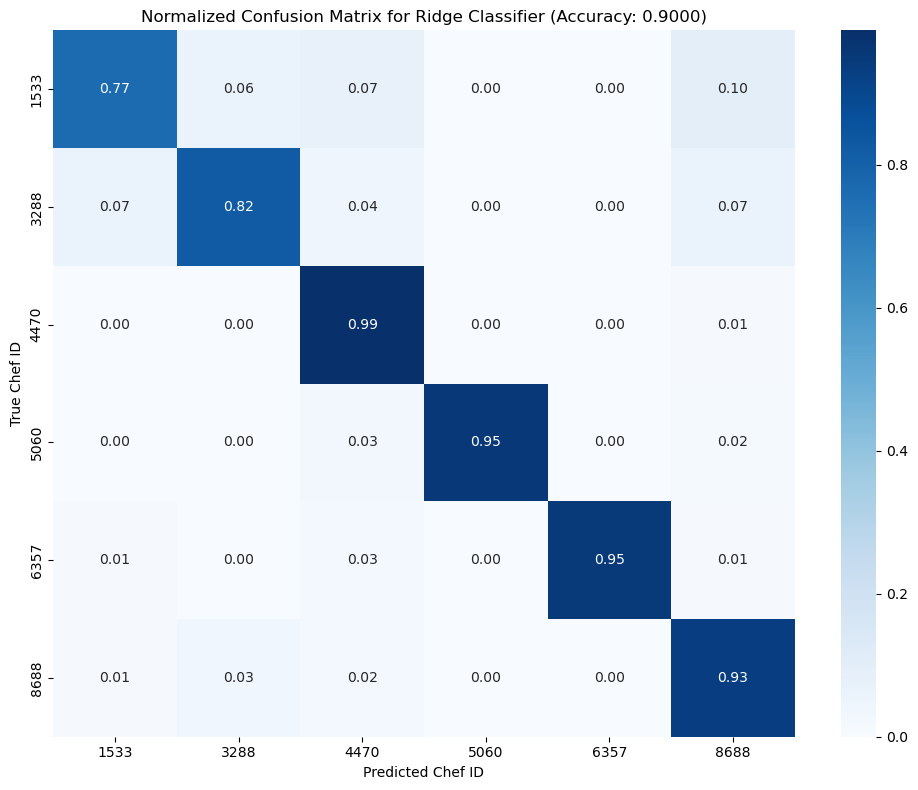

In [19]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from utils import run_kfold_experiment
from sklearn.metrics import confusion_matrix

# config
INPUT_EXCEL = "results/log.xlsx"
# REMEMBER: when using categorical and numerical features, set column names here
CATEGORICAL_COLS = None  # e.g. "tags" or ["tags", ...] if multiple, etc
NUMERICAL_COLS = numerical_features
skip_sub_words = True

# excel with results
df = pd.read_excel(INPUT_EXCEL)


def get_best_algo(file_path, skip_sub_words=False):
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Iterate over rows starting from the second row (index 1)
    for index, row in df.iterrows():
        description = row["description"]

        # Check if "sub_words" is in the description and whether to skip
        if skip_sub_words and "sub_words" in description:
            continue  # Skip this row if it contains "sub_words"

        # If we reach here, it means this row is valid
        return description

    # If no valid description is found, return None (or handle as you wish)
    return None


# get bets model
best_algo = get_best_algo(INPUT_EXCEL, skip_sub_words)

print(best_algo)

# best_algo = results.iloc[0]["Algorithm"]             # LightGBM (preprocessed data) | Text | Unigrams + Bigrams

# parse best model attributes
parts = [p.strip() for p in best_algo.split("|")]
base_with_data = parts[0]  # e.g. "LightGBM (preprocessed data)"
features = parts[1] if len(parts) > 1 else ""  # e.g. "Text", "Text + Numerical", etc
tfidf_desc = parts[-1] if len(parts) >= 3 else None  # e.g. "Unigrams + Bigrams"

# extract base model and data tag
m = re.match(r"^(.*?) \((.*?) data\)$", base_with_data)
if not m:
    raise ValueError(f"Could not extract base model / data tag from: {base_with_data}")

base_model, data_tag = m.group(1), m.group(2)

# choose the correct input file
if data_tag not in input_files:
    raise KeyError(f"Unknown data tag '{data_tag}'. Known: {list(input_files.keys())}")
INPUT_FILE = input_files[data_tag]

# recover the estimator class/kwargs from your models list
try:
    cls, kwargs, best_model_name = next(
        (c, k, d) for c, k, d in models if d == base_model
    )
except StopIteration:
    raise ValueError(
        f"Could not match model '{base_model}' in models. Available: {[d for _,_,d in models]}"
    )

# build text_columns if this run used Text + a TF-IDF config in Algorithm
if "Text" in features:
    if tfidf_desc is None:
        raise ValueError(
            f"'Algorithm' indicates Text features but no TF-IDF description found: {best_algo}"
        )
    cfg = next((c for c in tfidf_configs if c["description"] == tfidf_desc), None)
    if cfg is None:
        raise ValueError(f"TF-IDF config '{tfidf_desc}' not found in tfidf_configs.")
    tfidf_params = {k: v for k, v in cfg.items() if k != "description"}
    text_columns = {"document": tfidf_params}
else:
    text_columns = None

# toggle categorical / numerical columns if your feature string mentions them
categorical_columns = CATEGORICAL_COLS if "Categorical" in features else None
numerical_columns = NUMERICAL_COLS if "Numerical" in features else None

print(f"\n--- Running best model from results ---")
print(f"Model: {best_model_name}")
print(f"Data: {data_tag} -> {INPUT_FILE}")
print(f"Features: {features or '(none)'}")
if text_columns:
    print(f"TF-IDF: {tfidf_desc}")

# run & confusion Matrix
summary = run_kfold_experiment(
    folds_file=INPUT_FILE,
    model_cls=cls,
    text_columns=text_columns,
    categorical_columns=categorical_columns,
    numerical_columns=numerical_columns,
    model_kwargs=kwargs,
    model_desc=best_algo,
    random_seed=RANDOM_SEED,
    return_last=True,
    save_model=True,
)

last = summary["Last_Run"]
y_val = last["y_val"]
y_pred = last["y_pred"]

cm = confusion_matrix(y_val, y_pred, labels=sorted(np.unique(y_val)))
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

chef_ids = sorted(np.unique(y_val))
labels = [str(i) for i in chef_ids]

print(f"\n--- Generating Confusion Matrix for {best_model_name} ---")

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.title(
    f"Normalized Confusion Matrix for {best_model_name} "
    f'(Accuracy: {summary["Accuracy_Mean"]:.4f})'
)
plt.ylabel("True Chef ID")
plt.xlabel("Predicted Chef ID")
plt.tight_layout()
plt.show()

### Primary Misclassifications per Chef


In [20]:
errors_only = cm_normalized.copy()

np.fill_diagonal(errors_only, -1)

most_confused_indices = np.argmax(errors_only, axis=1)

confusion_with = []
for i, true_chef in enumerate(chef_ids):

    confusion_with.append(
        {
            "True_ID": true_chef,
            "Confused_ID": chef_ids[most_confused_indices[i]],
            "Misclassification_Rate": errors_only[i, most_confused_indices[i]],
        }
    )

confusion_with_df = pd.DataFrame(confusion_with)

print("\n--- Summary: Each Chef's Primary Source of Confusion ---")
print("-------------------------------------------------------")
print(confusion_with_df.to_string(index=False, float_format="%.3f"))


--- Summary: Each Chef's Primary Source of Confusion ---
-------------------------------------------------------
 True_ID  Confused_ID  Misclassification_Rate
    1533         8688                   0.099
    3288         1533                   0.067
    4470         8688                   0.012
    5060         4470                   0.028
    6357         4470                   0.027
    8688         3288                   0.035


### Detailed Misclassified Recipes


In [21]:
val_df = last["val_df"]
y_val = last["y_val"]
y_pred = last["y_pred"]

# Fetch all of the misclassified samples (Actual ID != Predicted ID)
misclassified_recipes_data = val_df[(y_val.to_numpy() != y_pred)].copy()

# Add the real and predicted ids
misclassified_recipes_data["True_Chef_ID"] = y_val[(y_val.to_numpy() != y_pred)].values
misclassified_recipes_data["Predicted_Chef_ID"] = y_pred[(y_val.to_numpy() != y_pred)]

# Select the most relevant columns for review
misclassified_output = misclassified_recipes_data[
    ["True_Chef_ID", "Predicted_Chef_ID", "document"]
]

# Count the total misclassified samples
total_misclassified = len(misclassified_output)

print(f"\n\n--- Detailed List of Misclassified Recipes ({best_model_name}) ---")
print(f"Total Validation Recipes: {len(y_val)}")
print(
    f"Total Misclassified Recipes: {total_misclassified} ({total_misclassified/len(y_val):.2%})"
)
print("-----------------------------------------------------------------")
print(misclassified_output.to_string(index=True, float_format="%.0f"))



--- Detailed List of Misclassified Recipes (Ridge Classifier) ---
Total Validation Recipes: 600
Total Misclassified Recipes: 52 (8.67%)
-----------------------------------------------------------------
     True_Chef_ID  Predicted_Chef_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

CHEF_1 = 1533
CHEF_2 = 8688
TOP_N = 20

# Read the preprocessed dataset
df = pd.read_csv("data/strong_baseline/folds_preprocessed.csv", sep=",")
df.columns = df.columns.str.strip()

# Recipes and their respective chef IDs
X = df["document"]
y = df["chef_id"]

# Separate the recipes by chef
text_chef_1_recipes = df[y == CHEF_1]["document"]
text_chef_2_recipes = df[y == CHEF_2]["document"]

# Configuration: Find all unigrams and bigrams in the entire dataset and removing stopword in english.
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")

# Vocabulary: Build the vocabulary from the entire dataset identifying all unigrams, bigrams and their IDF weights
X_tfidf_full = tfidf_vectorizer.fit_transform(X)
# List of all Unigrams and Bigrams found in the entire dataset
feature_names = tfidf_vectorizer.get_feature_names_out()

# Weight matrix for each chef's 1533 recipes
X_1533_tfidf = tfidf_vectorizer.transform(text_chef_1_recipes)
# Weight matrix for each chef's 8688 recipes
X_8688_tfidf = tfidf_vectorizer.transform(text_chef_2_recipes)


# X_tfidf_subset: Weight matrix for the specific chef's recipes
# feature_names: List of all Unigrams and Bigrams found in the entire dataset
# Basically sums the weights for each unigram, bigram across all recipes of the chef
def get_top_tfidf_ngrams(X_tfidf_subset, feature_names):
    """
    Calculates the total cumulative TF-IDF weight for each feature used by a chef.
    """

    # Sum the TF-IDF weights for each feature across all recipes of the chef
    feature_sums = X_tfidf_subset.sum(axis=0).A1

    # Create dictionary
    chef_scores = dict(zip(feature_names, feature_sums))
    top_ngrams = Counter(chef_scores).most_common(TOP_N)

    return top_ngrams


print("\n" + "=" * 80)
print(f"|  TOP {TOP_N} N-GRAMS BY CUMULATIVE TF-IDF WEIGHT - CHEF {CHEF_1}  |")
print("=" * 80)
top_ngrams_1 = get_top_tfidf_ngrams(X_1533_tfidf, feature_names)
for ngram, score in top_ngrams_1:
    print(f"{ngram:<40}: {score:.4f}")

print("\n" + "=" * 80)
print(f"|  TOP {TOP_N} N-GRAMS BY CUMULATIVE TF-IDF WEIGHT - CHEF {CHEF_2}  |")
print("=" * 80)
top_ngrams_2 = get_top_tfidf_ngrams(X_8688_tfidf, feature_names)
for ngram, score in top_ngrams_2:
    print(f"{ngram:<40}: {score:.4f}")


|  TOP 20 N-GRAMS BY CUMULATIVE TF-IDF WEIGHT - CHEF 1533  |
cheese                                  : 9.7864
pepper                                  : 9.4978
add                                     : 8.1717
chicken                                 : 8.1335
oil                                     : 7.8839
minutes                                 : 7.6613
heat                                    : 7.4208
healthy                                 : 7.1248
juice                                   : 6.8946
salt                                    : 6.6514
garlic                                  : 6.6330
vegetables                              : 6.4919
mainingredient preparation              : 6.3460
oven                                    : 6.2336
minutesorless                           : 6.1796
minutesorless timetomake                : 6.1645
equipment                               : 5.8725
dietary                                 : 5.8049
onion                                   : 5.7843
course 

# Final Results

### Preprocessing

In [21]:
import re
import numpy as np
import pandas as pd
import ast
from nltk.corpus import stopwords
# config
OUTPUT_PATH = "data/final.csv"

data = pd.read_csv("data/test-no-labels.csv", sep=";")
# --- Step 1: extract numerical features ---

# ---------------------------
# Helper functions
# ---------------------------

def safe_list_parse(x):
    """Parse stringified lists like "['a','b']" or '["a", "b"]'."""
    s = "" if x is None else str(x).strip()
    if not s:
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return [str(t).strip() for t in v if str(t).strip()]
    except Exception:
        pass
    s = s.strip("[]")
    parts = [p.strip().strip("'").strip('"') for p in s.split(",")]
    return [p for p in parts if p]

word_re = re.compile(r"[A-Za-z]+")

def tokenize_words(text):
    return word_re.findall("" if text is None else str(text))

def count_words(text):
    return len(tokenize_words(text))

def mentions_time(text):
    t = ("" if text is None else str(text)).lower()
    return int(bool(re.search(r"\b(min(ute)?s?|hr|hrs|hour|hours|sec|secs|second|seconds)\b", t)))

def mentions_temp(text):
    t = ("" if text is None else str(text)).lower()
    return int(bool(re.search(r"(\d+\s?°\s?[cf])|\b(degree|degrees|°c|°f|celsius|fahrenheit|temperature)\b", t)))

ACTIONS = {
    "mix","stir","bake","cook","heat","fry","chop","add","boil","grill",
    "combine","serve","pour","slice","beat","whisk","saute","preheat","season"
}

def count_actions(text):
    toks = [w.lower() for w in tokenize_words(text)]
    return sum(1 for w in toks if w in ACTIONS)


# ---------------------------
# Numerical feature extraction
# ---------------------------

steps_list = data["steps"].apply(safe_list_parse)
ing_list   = data["ingredients"].apply(safe_list_parse)

# Build raw text for counting
raw_text_for_counts = (
    data["recipe_name"].fillna("").astype(str) + " " +
    data["description"].fillna("").astype(str) + " " +
    steps_list.apply(lambda xs: " ".join(xs)) + " " +
    ing_list.apply(lambda xs: " ".join(xs))
)

# Core features
data["description_length"] = raw_text_for_counts.apply(count_words)
data["mentions_time"]      = raw_text_for_counts.apply(mentions_time)
data["mentions_temp"]      = raw_text_for_counts.apply(mentions_temp)
data["n_actions"]          = raw_text_for_counts.apply(count_actions)

# Step-based features
data["n_steps"] = steps_list.apply(len)
data["avg_step_length"] = steps_list.apply(
    lambda xs: float(np.mean([len(tokenize_words(s)) for s in xs])) if len(xs)>0 else 0.0
)
data["tokens_per_step"] = data.apply(
    lambda r: (r["description_length"]/r["n_steps"]) if r["n_steps"]>0 else 0.0, axis=1
)

# Title-based
data["recipe_name_length"] = data["recipe_name"].apply(count_words)

# Ensure no NaNs
numeric_features = [
    "n_ingredients",
    "description_length","n_steps","avg_step_length",
    "mentions_time","mentions_temp","n_actions","tokens_per_step",
    "recipe_name_length",
]
data[numeric_features] = data[numeric_features].fillna(0)

# --- Step 2: combine text fields ---

# all columns to be combined
text_columns = ["recipe_name", "description", "tags", "steps", "ingredients"]

# fill any potential missing values (NaN) with an empty string
for col in text_columns:
    data[col] = data[col].fillna("")

# columns that are string representations of lists
list_like_columns = ["tags", "steps", "ingredients"]

# remove list-like characters and commas
for col in list_like_columns:
    data[col] = (
        data[col]
        .str.strip("[]")
        .str.replace("'", "", regex=False)
        .str.replace('"', "", regex=False)
        .str.replace(",", "", regex=False)
    )

# concatenate columns, separated by spaces
data["document"] = data[text_columns].apply(lambda row: " ".join(row), axis=1)

# --- Step 3: clean and normalize the text ---

# convert to lowercase
data["document_cleaned"] = data["document"].str.lower()

# remove punctuation and numbers using a raw string for the regex pattern
data["document_cleaned"] = data["document_cleaned"].str.replace(
    r"[^a-z\s]", "", regex=True
)

# remove extra whitespace using a raw string
data["document_cleaned"] = (
    data["document_cleaned"].str.replace(r"\s+", " ", regex=True).str.strip()
)

# --- Step 4: handle stop words ---

# load standard set of English stop words
stop_words = set(stopwords.words("english"))

# remove stop words from the 'document_cleaned' column
# split each document into words and then rejoin only the words not in the stop_words set
data["document_no_stopwords"] = data["document_cleaned"].apply(
    lambda text: " ".join([word for word in text.split() if word not in stop_words])
)

selected_cols = ["document_no_stopwords", "data", "n_ingredients",
    "description_length","n_steps","avg_step_length",
    "mentions_time","mentions_temp","n_actions","tokens_per_step",
    "recipe_name_length"]

new_df = data[selected_cols].copy()

new_df["data"] = pd.to_datetime(new_df["data"], format="%d/%m/%Y", errors="coerce")

# extract features
new_df["year"] = new_df["data"].dt.year
new_df["month"] = new_df["data"].dt.month
new_df["day"] = new_df["data"].dt.day
new_df["day_of_week"] = new_df["data"].dt.dayofweek  # Monday=0, Sunday=6

# cyclic encoding for month and day_of_week
new_df["month_sin"] = np.sin(2 * np.pi * new_df["month"] / 12)
new_df["month_cos"] = np.cos(2 * np.pi * new_df["month"] / 12)

new_df["dow_sin"] = np.sin(2 * np.pi * new_df["day_of_week"] / 7)
new_df["dow_cos"] = np.cos(2 * np.pi * new_df["day_of_week"] / 7)
new_df = new_df.drop(columns=["data", "year", "month", "day", "day_of_week"])

new_df["document"] = new_df["document_no_stopwords"]
new_df.to_csv("data/final.csv", index=False)
print(new_df.columns.tolist())

data = pd.read_csv(input_files["all_inputs_default"], sep=";")
print(data.columns.tolist())

['document_no_stopwords', 'n_ingredients', 'description_length', 'n_steps', 'avg_step_length', 'mentions_time', 'mentions_temp', 'n_actions', 'tokens_per_step', 'recipe_name_length', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'document']
['chef_id,document_no_stopwords,n_ingredients,description_length,n_steps,avg_step_length,mentions_time,mentions_temp,n_actions,tokens_per_step,recipe_name_length,month_sin,month_cos,dow_sin,dow_cos,document,fold']


### Get results.txt

In [22]:
import joblib
import pandas as pd
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack, csr_matrix

# config
train_csv = input_files["all_inputs_default"]   # your dataset with a 'fold' column and 'chef_id'
text_col  = "document"                          # merged text column (incl. tags if you concatenated them)
num_cols  = [
    "n_ingredients","n_steps","description_length","mentions_time","mentions_temp",
    "n_actions","avg_step_length","tokens_per_step","recipe_name_length"
]
bundle_out = "models/ridge_final_bundle.joblib"

# --- load data ---
df = pd.read_csv(train_csv)
if "fold" not in df.columns:
    raise KeyError("Column 'fold' not found in the dataset.")
if "chef_id" not in df.columns:
    raise KeyError("Target column 'chef_id' not found in the dataset.")
for c in [text_col] + num_cols:
    if c not in df.columns:
        raise KeyError(f"Required column '{c}' not found in the dataset.")

# --- split using your folds: validate on fold == 1 ---
train_df = df[df["fold"] != 1].reset_index(drop=True)
val_df   = df[df["fold"] == 1].reset_index(drop=True)

# --- vectorizers/scaler (same params you reported) ---
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, lowercase=True, token_pattern=r"(?u)\b[a-z]{2,}\b")
scaler = StandardScaler()

# --- fit on TRAIN, transform TRAIN/VAL ---
Xtr_text = tfidf.fit_transform(train_df[text_col].fillna(""))
Xva_text = tfidf.transform(val_df[text_col].fillna(""))

Xtr_num = scaler.fit_transform(train_df[num_cols].astype(float))
Xva_num = scaler.transform(val_df[num_cols].astype(float))

Xtr = hstack([Xtr_text, csr_matrix(Xtr_num)], format="csr")
Xva = hstack([Xva_text, csr_matrix(Xva_num)], format="csr")

ytr = train_df["chef_id"].values
yva = val_df["chef_id"].values

# --- train & evaluate on fold-1 split ---
clf = RidgeClassifier()
clf.fit(Xtr, ytr)
preds = clf.predict(Xva)
acc = accuracy_score(yva, preds)
print(f"Validation accuracy on fold==1: {acc:.4f}")

# ---------- retrain on ALL rows (same preprocessors) and save bundle ----------
# Refit TF-IDF & scaler on ALL data to maximize final model capacity
Xall_text = tfidf.fit_transform(df[text_col].fillna(""))
Xall_num  = scaler.fit_transform(df[num_cols].astype(float))
Xall = hstack([Xall_text, csr_matrix(Xall_num)], format="csr")
yall = df["chef_id"].values

final_clf = RidgeClassifier()
final_clf.fit(Xall, yall)

bundle = {
    "tfidf": tfidf,
    "scaler": scaler,
    "model": final_clf,
    "text_col": text_col,
    "num_cols": num_cols
}
joblib.dump(bundle, bundle_out)
print(f"✅ Saved final bundle to {bundle_out}")


Validation accuracy on fold==1: 0.9133
✅ Saved final bundle to models/ridge_final_bundle.joblib


In [23]:
import joblib
import pandas as pd
from scipy.sparse import hstack, csr_matrix

# --- 1. Load bundle and new data ---
bundle = joblib.load("models/ridge_final_bundle.joblib")
data = pd.read_csv("data/final.csv")

# --- 2. Extract preprocessing tools ---
tfidf = bundle["tfidf"]
scaler = bundle["scaler"]
model = bundle["model"]
num_cols = bundle["num_cols"]
text_col = bundle["text_col"]

# --- 3. Transform new data ---
X_text = tfidf.transform(data[text_col].fillna(""))
X_num = scaler.transform(data[num_cols])
X_num = csr_matrix(X_num)
X = hstack([X_text, X_num])

# --- 4. Predict and save results ---
preds = model.predict(X)
with open("results.txt", "w") as f:
    f.writelines(f"{p}\n" for p in preds)

print(f"✅ Saved {len(preds)} predictions to results.txt")


✅ Saved 823 predictions to results.txt
